In [1]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import yfinance as yf
import matplotlib.pyplot as plt
import gym

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Define the environment
class StockMarketEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.start_date = '2020-01-01'
        self.end_date = '2022-01-01'
        self.ticker = 'AAPL'
        self.df = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        self.df = self.df.dropna()
        self.df['Returns'] = self.df['Close'].pct_change()
        self.df = self.df.iloc[1:]
        self.observations = len(self.df)
        self.state_shape = 1
        self.action_shape = 1
        self.state = np.array([[self.df['Returns'][0]]])

    def step(self, action):
        last_period_close = self.df['Close'][self.current_step-1]
        today_close = self.df['Close'][self.current_step]
        predicted_close = today_close*(1+action[0])
        self.df.loc[self.df.index[self.current_step], 'predicted_close'] = predicted_close
        signal = 0
        if predicted_close > last_period_close:
            signal = 1
        elif predicted_close < last_period_close:
            signal = -1
        reward = signal * self.df['Returns'][self.current_step]

        self.current_step += 1
        if self.current_step >= self.observations:
            done = True
        else:
            done = False
            self.state = np.array([[self.df['Returns'][self.current_step]]])
        return self.state, reward, done, {}

    def reset(self):
        self.current_step =0

        self.state = np.array([[self.df['Returns'][0]]])
        return self.state

    def render(self, mode='human'):
        pass

    def close(self):
        pass

# Define the agent
class DDPGAgent:
    def __init__(self, env):
        self.env = env
        self.gamma = 0.99
        self.tau = 0.001
        self.buffer_size = 100000
        self.batch_size = 6400
        self.replay_buffer = []
        self.q_model = models.Sequential([
            layers.Dense(64, activation='relu', input_shape=(env.state_shape + env.action_shape,)),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ])
        self.policy_model = models.Sequential([
            layers.Dense(64, activation='relu', input_shape=(env.state_shape,)),
            layers.Dense(32, activation='relu'),
            layers.Dense(env.action_shape, activation='tanh')
        ])
        self.q_optimizer = optimizers.Adam(learning_rate=0.001)
        self.policy_optimizer = optimizers.Adam(learning_rate=0.001)

    def ddpg(self, state, action, reward, next_state, done):
        # Add the transition to the replay buffer
        self.replay_buffer.append((state, action, reward, next_state, done))

        # Sample a batch of transitions from the replay buffer
        if len(self.replay_buffer) < self.batch_size:
            return
        batch = random.sample(self.replay_buffer, self.batch_size)
        states = np.array([transition[0] for transition in batch])
        actions = np.array([transition[1] for transition in batch])
        rewards = np.array([transition[2] for transition in batch])
        next_states = np.array([transition[3] for transition in batch])
        dones = np.array([transition[4] for transition in batch])

        # Update the Q-network
        with tf.GradientTape() as tape:
            target_actions = self.policy_model(next_states)
            target_q_values = self.q_model(tf.concat([next_states, target_actions], axis=1))
            target_y = rewards + self.gamma * (1 - dones) * target_q_values
            current_q_values = self.q_model(tf.concat([states, actions], axis=1))
            loss = tf.reduce_mean(tf.square(current_q_values - target_y))
        grads = tape.gradient(loss, self.q_model.trainable_weights)
        self.q_optimizer.apply_gradients(zip(grads, self.q_model.trainable_weights))

        # Update the policy network
        with tf.GradientTape() as tape:
            new_actions = self.policy_model(states)
            new_q_values = self.q_model(tf.concat([states, new_actions], axis=1))
            policy_loss = -tf.reduce_mean(new_q_values)
        grads = tape.gradient(policy_loss, self.policy_model.trainable_weights)
        self.policy_optimizer.apply_gradients(zip(grads, self.policy_model.trainable_weights))

        # Update the target networks
        self.update_target_network(self.q_model, self.tau)
        self.update_target_network(self.policy_model, self.tau)

    def update_target_network(self, model, tau):
        new_weights = []
        target_variables = model.weights
        for i, variable in enumerate(model.weights):
            target_variables[i] = variable * tau + target_variables[i] * (1 - tau)
        model.set_weights(target_variables)

    def evaluate(self):
        state = self.env.reset()
        done = False
        total_reward = 0
        while not done:
            action = self.policy_model.predict(state)
            next_state, reward, done, _ = self.env.step(action)
            total_reward += reward
            state = next_state
        return total_reward

    def test(self, episodes=10):
        scores = []
        for episode in range(episodes):
            score = self.evaluate()
            scores.append(score)
        print('Average Score:', np.mean(scores))

    def train(self, episodes=10):
        for episode in range(episodes):
            state = self.env.reset()
            done = False
            episode_reward = 0
            while not done:
                action = self.policy_model.predict(state)
                next_state, reward, done, _ = self.env.step(action)
                episode_reward += reward
                self.ddpg(state, action, reward, next_state, done)
                state = next_state
            print(f'Episode: {episode+1}/{episodes}, Episode Reward: {episode_reward}')
        self.test()

    def predict_next_returns(self, n=10):
        returns = []
        state = self.env.reset()
        for i in range(n):
            action = self.policy_model.predict(state)
            state, _, _, _ = self.env.step(action)
            returns.append(state[0][0])
        return returns

# Train the agent and print the test results
env = StockMarketEnv()
agent = DDPGAgent(env)
agent.train()
print('Predicted Returns:', agent.predict_next_returns())

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 69ms/step
Average Score: 8.232494921971186
1/1 [==============================] - 0s 30ms/step
Predicted Returns: [0.007968245219206693, -0.0047030460371630944, 0.016086288271489613, 0.021240813976545425, 0.0022607036734636488, 0.02136437073337283, -0.013503277683875936, -0.004285519922216707, 0.012526478905240834, 0.011070996257037002]


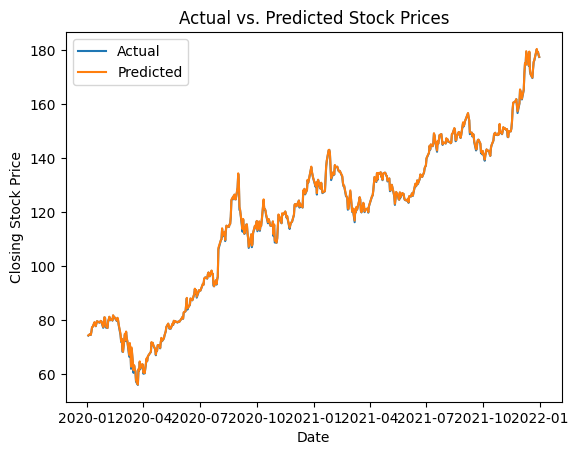

In [3]:
# Plot the actual and predicted stock prices
dates = pd.to_datetime(env.df.index)
actual_prices = env.df['Close']
predicted_prices = env.df['predicted_close']
plt.plot(dates, actual_prices, label='Actual')
plt.plot(dates, predicted_prices, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()